In [ ]:
import array
import functools
import gzip
import operator
import os
import struct
from tempfile import NamedTemporaryFile
from urllib.parse import urljoin
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from tqdm.notebook import tqdm as TQDM

In [ ]:
class IdxDecodeError(ValueError):
    """Raised when an invalid idx file is parsed."""
    pass


def parse_idx(fd):
    """Parse an IDX file, and return it as a numpy array.

    Parameters
    ----------
    fd : file
        File descriptor of the IDX file to parse

    endian : str
        Byte order of the IDX file. See [1] for available options

    Returns
    -------
    data : numpy.ndarray
        Numpy array with the dimensions and the data in the IDX file

    1. https://docs.python.org/3/library/struct.html
        #byte-order-size-and-alignment
    """
    DATA_TYPES = {0x08: 'B',  # unsigned byte
                  0x09: 'b',  # signed byte
                  0x0b: 'h',  # short (2 bytes)
                  0x0c: 'i',  # int (4 bytes)
                  0x0d: 'f',  # float (4 bytes)
                  0x0e: 'd'}  # double (8 bytes)

    header = fd.read(4)
    if len(header) != 4:
        raise IdxDecodeError('Invalid IDX file, '
                             'file empty or does not contain a full header.')

    zeros, data_type, num_dimensions = struct.unpack('>HBB', header)

    if zeros != 0:
        raise IdxDecodeError('Invalid IDX file, '
                             'file must start with two zero bytes. '
                             'Found 0x%02x' % zeros)

    try:
        data_type = DATA_TYPES[data_type]
    except KeyError:
        raise IdxDecodeError('Unknown data type '
                             '0x%02x in IDX file' % data_type)

    dimension_sizes = struct.unpack('>' + 'I' * num_dimensions,
                                    fd.read(4 * num_dimensions))

    data = array.array(data_type, fd.read())
    data.byteswap()  # looks like array.array reads data as little endian

    expected_items = functools.reduce(operator.mul, dimension_sizes)
    if len(data) != expected_items:
        raise IdxDecodeError('IDX file has wrong number of items. '
                             'Expected: %d. Found: %d' % (expected_items,
                                                          len(data)))

    return np.array(data).reshape(dimension_sizes)


In [ ]:
datasets_url = 'https://ossci-datasets.s3.amazonaws.com/mnist/'

def get_data(file : str):
    with NamedTemporaryFile("wb", suffix=".gz") as f:
        urlretrieve(
            urljoin(datasets_url, file),
            f.name   
        )
        with gzip.open(f.name, "rb") as zf:
            return parse_idx(zf)

def prepare_mnist_for_minitrainer(images, labels, what, max_count=None):
    label_count = {}
    for image, label in TQDM(zip(images, labels), desc="Writing MNIST dataset to disk...", total=len(images)):
        label_count[label] = label_count.get(label, -1) + 1
        if max_count is not None and label_count[label] > max_count:
            continue
        image_path = os.path.join("mnist", what, f'{label}', f'{label_count[label]}.png')
        os.makedirs(os.path.dirname(image_path), exist_ok=True)
        Image.fromarray(np.broadcast_to(image[:, :, np.newaxis], (*image.shape, 3))).save(image_path)

def prepare_train_mnist_for_minitrainer():
    train_images_file = 'train-images-idx3-ubyte.gz'
    train_labels_file = 'train-labels-idx1-ubyte.gz'

    train_labels = get_data(train_labels_file)
    train_images = get_data(train_images_file)

    prepare_mnist_for_minitrainer(train_images, train_labels, "train", 500)

def prepare_test_mnist_for_minitrainer():
    test_images_file = 't10k-images-idx3-ubyte.gz'
    test_labels_file = 't10k-labels-idx1-ubyte.gz'

    test_labels = get_data(test_labels_file)
    test_images = get_data(test_images_file)

    prepare_mnist_for_minitrainer(test_images, test_labels, "test", 500)

prepare_train_mnist_for_minitrainer()
prepare_test_mnist_for_minitrainer()

In [ ]:
!cd mnist && mt_train -i train --model efficientnet_b0 --batch_size 64 --epochs 5 --warmup_epochs 2
# !python ../../predict.py -i test -w 

In [26]:
!pwd

/home/asger/mini_trainer/examples


In [35]:
!cd mnist && mt_predict -i test --class_index class_index.json --model efficientnet_b0 --weights efficientnet_b0_full_e5.pt --training_format --dtype float32

Running inference...: 100%|███████████████████| 157/157 [00:04<00:00, 32.56it/s]
Outputs written to /home/asger/mini_trainer/examples/mnist/result.json
Inference took 5.0s (998.3 img/s)
495|   |   |  1|   |  2|  1|   |  1|  1
   |487|  3|  1|  6|   |   |  4|   |   
  7|   |392| 23|  6| 59|  9|  1|  4|   
  2|   |  8|484|   |  4|   |   |  3|   
   |   |  2|  1|493|   |   |   |  2|  3
   |  1| 37| 77|  1|376|  1|  3|  5|   
 31|  3|  9|   |   |  2|424|  3|  3| 26
  8| 23| 17| 16| 46|  4|   |386|  1|   
  3|   |  2|  3|  1|   |   |   |491|  1
 18|  4| 13|   | 10| 12| 27|  3| 12|402

Per-class Accuracies:
0____98.8% (495/501)
1____97.2% (487/501)
2____78.2% (392/501)
3____96.6% (484/501)
4____98.4% (493/501)
5____75.0% (376/501)
6____84.6% (424/501)
7____77.0% (386/501)
8____98.0% (491/501)
9____80.2% (402/501)

Micro Accuracy: 88.42% (4430/5010)
Macro Accuracy: 88.42%


In [2]:
import torch
from mini_trainer.builders import base_model_builder

device, dtype = torch.device("cuda:0"), torch.float32

model, mproc = base_model_builder(
    "efficientnet_b0",
    "mnist/efficientnet_b0_full_e5.pt",
    False,
    device,
    dtype,
    10
)
model.eval()
pass

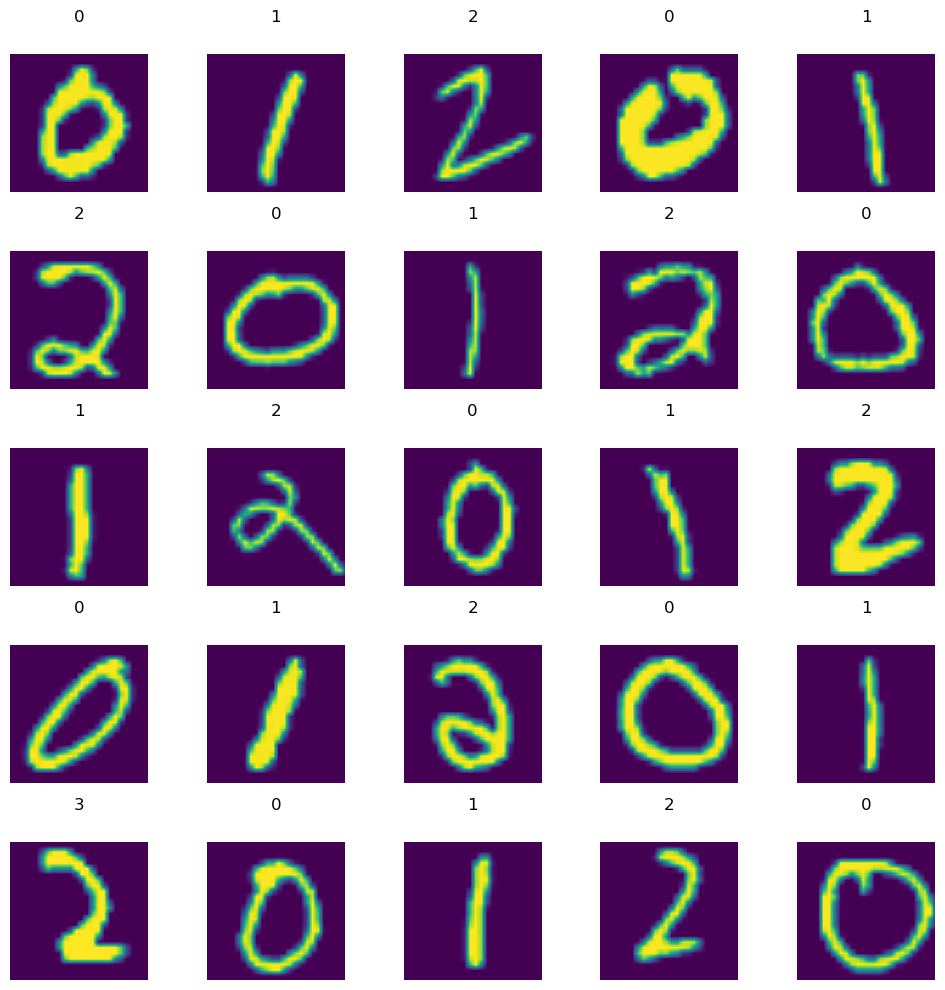

In [8]:
from matplotlib import pyplot as plt

from mini_trainer.predict import ImageLoader
from mini_trainer.utils import BaseResultCollector

images = [f"/home/asger/mini_trainer/examples/mnist/test/{i % 3}/{i}.png" for i in range(25)]
ds = ImageLoader(mproc, dtype, device)(images)
results = BaseResultCollector({i : f'{i}' for i in range(10)}, True)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    tim = ds[i]
    with torch.no_grad():
        prediction = model(tim.unsqueeze(0))
    ax.matshow(tim.permute(1, 2, 0).cpu().mean(dim=2))
    ax.set_title(prediction.argmax().item())
    ax.axis("off")
    results.collect([images[i]], prediction)

plt.tight_layout()
plt.show()

In [9]:
results.evaluate()

9| | | | | | | | | 
 |8| | | | | | | | 
 | |7|1| | | | | | 
 | | | | | | | | | 
 | | | | | | | | | 
 | | | | | | | | | 
 | | | | | | | | | 
 | | | | | | | | | 
 | | | | | | | | | 
 | | | | | | | | | 

Per-class Accuracies:
0___100.0% (9/9)
1___100.0% (8/8)
2____87.5% (7/8)
3_____0.0% (0/0)
4_____0.0% (0/0)
5_____0.0% (0/0)
6_____0.0% (0/0)
7_____0.0% (0/0)
8_____0.0% (0/0)
9_____0.0% (0/0)

Micro Accuracy: 96.00% (24/25)
Macro Accuracy: 95.83%


In [24]:
results = BaseResultCollector({i : f'{i}' for i in range(10)}, True)
images = [f"/home/asger/mini_trainer/examples/mnist/test/{(i + 1) % 10}/{i}.png" for i in range(500)]
ds = ImageLoader(mproc, dtype, device)(images)
for b in range(99):
    bis = list(range(b*5, b*5+5))
    with torch.no_grad():
        predictions = model(torch.stack([ds[i] for i in bis]))
    results.collect([images[i] for i in bis], predictions)
results.evaluate()

49|  |  |  |  |  |  |  |  |  
  |48|  |  | 1|  |  | 1|  |  
  |  |39| 2|  | 7| 1|  | 1|  
  |  |  |49|  | 1|  |  |  |  
  |  | 1|  |48|  |  |  |  | 1
  | 1| 4|12|  |31| 1| 1|  |  
 4|  | 1|  |  |  |43|  |  | 1
  |  | 1| 4| 5|  |  |39|  |  
  |  |  |  |  |  |  |  |49|  
 1| 1| 2|  | 2| 1| 2|  | 3|37

Per-class Accuracies:
0___100.0% (49/49)
1____96.0% (48/50)
2____78.0% (39/50)
3____98.0% (49/50)
4____96.0% (48/50)
5____62.0% (31/50)
6____87.8% (43/49)
7____79.6% (39/49)
8___100.0% (49/49)
9____75.5% (37/49)

Micro Accuracy: 87.27% (432/495)
Macro Accuracy: 87.29%
